# Task 6: Stock Market Prediction using Numerical and Textual Analysis

Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines

In [1]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [2]:
# reading the datasets into pandas
stock_price = pd.read_csv('INTC.csv')
stock_headlines = pd.read_csv('india-news-headlines.csv')

In [3]:
# displaying stock price dataset:
stock_price

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-17,62.020000,62.130001,59.830002,60.360001,58.828499,27385600
1,2020-04-20,59.279999,60.040001,58.889999,59.180000,57.678440,26420300
2,2020-04-21,58.110001,58.599998,55.930000,56.360001,54.929993,25248000
3,2020-04-22,58.270000,60.500000,57.810001,60.099998,58.575100,23443700
4,2020-04-23,59.669998,60.099998,58.810001,59.040001,57.541996,35092000
...,...,...,...,...,...,...,...
247,2021-04-12,68.199997,68.489998,64.709999,65.410004,65.410004,51266900
248,2021-04-13,65.610001,65.629997,64.209999,65.220001,65.220001,26822000
249,2021-04-14,65.309998,65.379997,63.840000,64.190002,64.190002,25768400
250,2021-04-15,63.970001,65.220001,63.680000,65.019997,65.019997,24916000


In [4]:
# displaying stock news headlines dataset:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [5]:
# dropping duplicates
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2020-04-17,60.360001,62.020000,62.130001,59.830002,27385600
2020-04-20,59.180000,59.279999,60.040001,58.889999,26420300
2020-04-21,56.360001,58.110001,58.599998,55.930000,25248000
2020-04-22,60.099998,58.270000,60.500000,57.810001,23443700
2020-04-23,59.040001,59.669998,60.099998,58.810001,35092000
...,...,...,...,...,...
2021-04-12,65.410004,68.199997,68.489998,64.709999,51266900
2021-04-13,65.220001,65.610001,65.629997,64.209999,26822000
2021-04-14,64.190002,65.309998,65.379997,63.840000,25768400


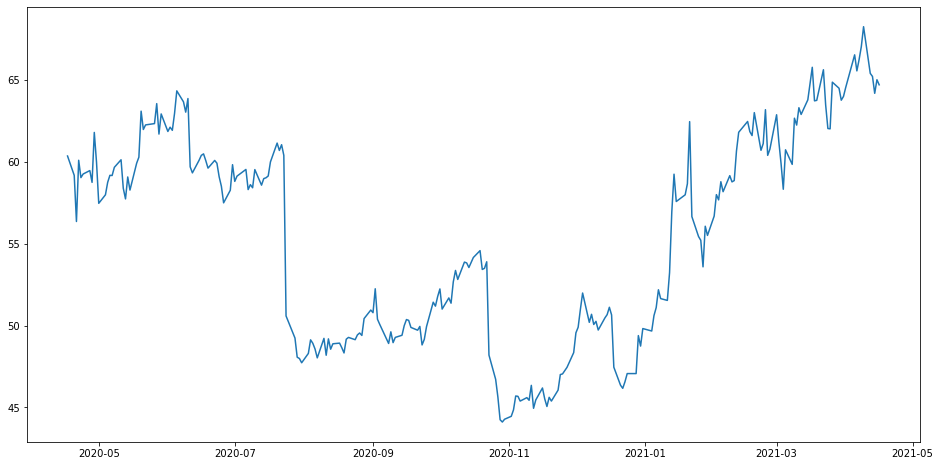

In [6]:
#plot
plt.figure(figsize=(16,8))
plt.plot(stock_price['Close'], label='Close Price history')

In [7]:
# displaying number of records in both stock_price and stock_headlines datasets
len(stock_price), len(stock_headlines)

(252, 3424067)

In [8]:
# checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Close     False
 Open      False
 High      False
 Low       False
 Volume    False
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

In [9]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

In [10]:
# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [11]:
# concatenating the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2020-04-17,60.360001,62.020000,62.130001,59.830002,27385600.0,"Police arrest 13 Myanmar nationals,Animals don..."
2020-04-20,59.180000,59.279999,60.040001,58.889999,26420300.0,In first quarter of 2020; fatal accidents on e...
2020-04-21,56.360001,58.110001,58.599998,55.930000,25248000.0,"60-year-old held with marijuana in Daulatabad,..."
2020-04-22,60.099998,58.270000,60.500000,57.810001,23443700.0,Sugar mills in Belagavi owe Rs 496cr to cane g...
2020-04-23,59.040001,59.669998,60.099998,58.810001,35092000.0,Parents seeks CM help for home delivery of tex...
...,...,...,...,...,...,...
2020-12-24,47.070000,46.599998,47.090000,46.340000,11865600.0,How to set the mood for sex during cold winter...
2020-12-28,47.070000,47.189999,47.639999,46.860001,21269200.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,49.389999,47.220001,50.669998,46.490002,84531400.0,Man recovers charred remains of 'thief' from h...
2020-12-30,48.750000,49.110001,49.189999,48.560001,37385400.0,Numerology Readings 30 December 2020: Predicti...


In [12]:
# adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-04-17,60.360001,62.020000,62.130001,59.830002,27385600.0,"Police arrest 13 Myanmar nationals,Animals don...",,,,
2020-04-20,59.180000,59.279999,60.040001,58.889999,26420300.0,In first quarter of 2020; fatal accidents on e...,,,,
2020-04-21,56.360001,58.110001,58.599998,55.930000,25248000.0,"60-year-old held with marijuana in Daulatabad,...",,,,
2020-04-22,60.099998,58.270000,60.500000,57.810001,23443700.0,Sugar mills in Belagavi owe Rs 496cr to cane g...,,,,
2020-04-23,59.040001,59.669998,60.099998,58.810001,35092000.0,Parents seeks CM help for home delivery of tex...,,,,


In [13]:
# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

In [14]:
# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-04-17,60.360001,62.020000,62.130001,59.830002,27385600.0,"Police arrest 13 Myanmar nationals,Animals don...",-0.9998,0.134,0.793,0.073
2020-04-20,59.180000,59.279999,60.040001,58.889999,26420300.0,In first quarter of 2020; fatal accidents on e...,-0.9994,0.122,0.786,0.092
2020-04-21,56.360001,58.110001,58.599998,55.930000,25248000.0,"60-year-old held with marijuana in Daulatabad,...",-0.9989,0.115,0.791,0.094
2020-04-22,60.099998,58.270000,60.500000,57.810001,23443700.0,Sugar mills in Belagavi owe Rs 496cr to cane g...,-0.9997,0.129,0.789,0.082
2020-04-23,59.040001,59.669998,60.099998,58.810001,35092000.0,Parents seeks CM help for home delivery of tex...,-0.9991,0.111,0.804,0.085


In [15]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-04-17,60.360001,-0.9998,0.134,0.793,0.073,62.020000,62.130001,59.830002,27385600.0
2020-04-20,59.180000,-0.9994,0.122,0.786,0.092,59.279999,60.040001,58.889999,26420300.0
2020-04-21,56.360001,-0.9989,0.115,0.791,0.094,58.110001,58.599998,55.930000,25248000.0
2020-04-22,60.099998,-0.9997,0.129,0.789,0.082,58.270000,60.500000,57.810001,23443700.0
2020-04-23,59.040001,-0.9991,0.111,0.804,0.085,59.669998,60.099998,58.810001,35092000.0


In [16]:
# writing the prepared stock_data to disk
stock_data.to_csv('stock_data.csv')

In [17]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('stock_data.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-04-17,60.360001,-0.9998,0.134,0.793,0.073,62.020000,62.130001,59.830002,27385600.0
2020-04-20,59.180000,-0.9994,0.122,0.786,0.092,59.279999,60.040001,58.889999,26420300.0
2020-04-21,56.360001,-0.9989,0.115,0.791,0.094,58.110001,58.599998,55.930000,25248000.0
2020-04-22,60.099998,-0.9997,0.129,0.789,0.082,58.270000,60.500000,57.810001,23443700.0
2020-04-23,59.040001,-0.9991,0.111,0.804,0.085,59.669998,60.099998,58.810001,35092000.0


In [18]:
# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(180, 9)

In [19]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,1.800000e+02
mean,53.264722,-0.988273,0.124417,0.797306,0.078222,53.295278,53.954389,52.620222,3.186041e+07
std,5.792788,0.148847,0.017293,0.023893,0.011672,5.792712,5.895122,5.630555,1.891493e+07
min,44.110001,-0.999900,0.082000,0.742000,0.047000,44.099998,44.470001,43.610001,1.186560e+07
25%,48.905000,-0.999800,0.113000,0.783000,0.070000,48.834999,49.397501,48.479999,2.156360e+07
50%,51.000000,-0.999700,0.125500,0.793500,0.078000,51.105002,51.620001,50.270001,2.765480e+07
75%,59.147499,-0.999475,0.136000,0.813250,0.085250,59.212499,59.860002,58.405001,3.535725e+07
max,64.339996,0.997400,0.169000,0.867000,0.127000,63.970001,65.110001,63.160000,1.822699e+08


In [20]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 2020-04-17 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     180 non-null    float64
 1   compound  180 non-null    float64
 2   negative  180 non-null    float64
 3   neutral   180 non-null    float64
 4   positive  180 non-null    float64
 5   Open      180 non-null    float64
 6   High      180 non-null    float64
 7   Low       180 non-null    float64
 8   Volume    180 non-null    float64
dtypes: float64(9)
memory usage: 14.1+ KB


Text(0, 0.5, 'Close Price ($)')

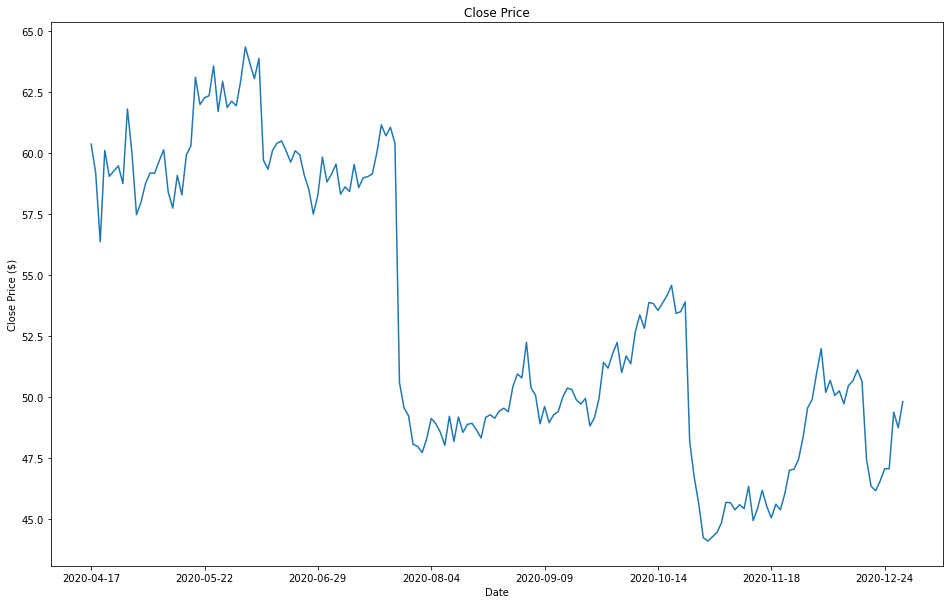

In [21]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

<AxesSubplot:xlabel='Date'>

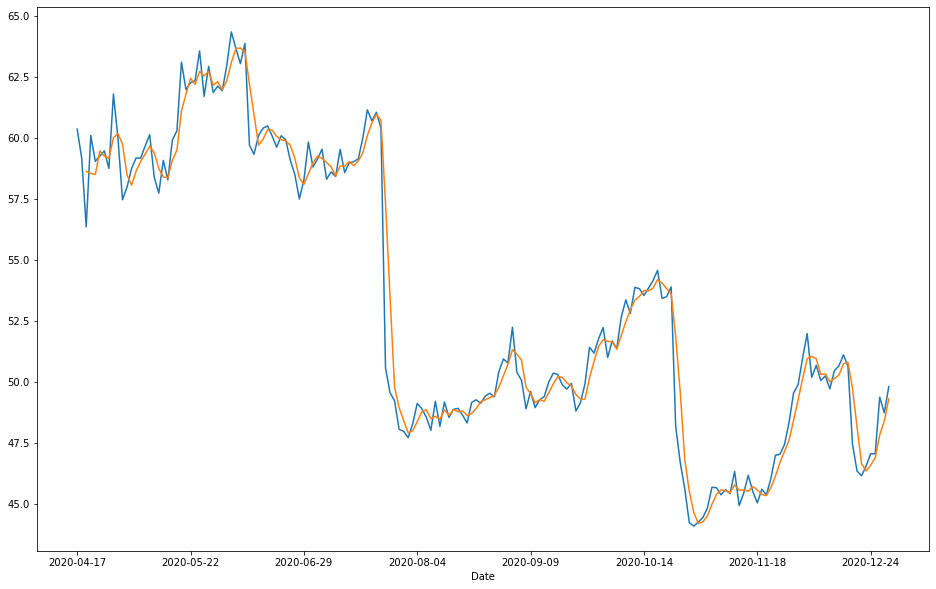

In [22]:
stock_data.rolling(7).mean().head(20)
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=3).mean()['Close'].plot()

In [23]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 143
Number of records in Test Data: 37


In [24]:

# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2020-04-20    59.180000
2020-04-21    56.360001
2020-04-22    60.099998
2020-04-23    59.040001
2020-04-24    59.259998
                ...    
2020-12-24    47.070000
2020-12-28    47.070000
2020-12-29    49.389999
2020-12-30    48.750000
2020-12-31    49.820000
Name: Close, Length: 179, dtype: float64

In [25]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2020-04-20,59.180000,56.360001,-0.9994,-0.9989,26420300.0,59.279999,60.040001,58.889999
2020-04-21,56.360001,60.099998,-0.9989,-0.9997,25248000.0,58.110001,58.599998,55.930000
2020-04-22,60.099998,59.040001,-0.9997,-0.9991,23443700.0,58.270000,60.500000,57.810001
2020-04-23,59.040001,59.259998,-0.9991,-0.9982,35092000.0,59.669998,60.099998,58.810001
2020-04-24,59.259998,59.470001,-0.9982,-0.9988,50220500.0,56.200001,59.400002,56.099998
2020-04-27,59.470001,58.750000,-0.9988,-0.9976,25902200.0,59.720001,59.830002,58.389999
2020-04-28,58.750000,61.799999,-0.9976,-0.9700,28784700.0,59.990002,60.220001,58.259998
2020-04-29,61.799999,59.980000,-0.9700,-0.9994,30451500.0,59.439999,62.029999,59.320000
2020-04-30,59.980000,57.470001,-0.9994,-0.9986,26279900.0,61.369999,61.540001,59.750000


In [26]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2020-04-20    56.360001
2020-04-21    60.099998
2020-04-22    59.040001
2020-04-23    59.259998
2020-04-24    59.470001
                ...    
2020-12-23    47.070000
2020-12-24    47.070000
2020-12-28    49.389999
2020-12-29    48.750000
2020-12-30    49.820000
Name: close_price_shifted, Length: 178, dtype: float64

In [27]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2020-04-20,59.180000,-0.9994,-0.9989,26420300.0,59.279999,60.040001,58.889999
2020-04-21,56.360001,-0.9989,-0.9997,25248000.0,58.110001,58.599998,55.930000
2020-04-22,60.099998,-0.9997,-0.9991,23443700.0,58.270000,60.500000,57.810001
2020-04-23,59.040001,-0.9991,-0.9982,35092000.0,59.669998,60.099998,58.810001
2020-04-24,59.259998,-0.9982,-0.9988,50220500.0,56.200001,59.400002,56.099998
...,...,...,...,...,...,...,...
2020-12-23,46.570000,-0.9996,-0.9971,22564200.0,46.169998,47.029999,46.070000
2020-12-24,47.070000,-0.9971,-0.9997,11865600.0,46.599998,47.090000,46.340000
2020-12-28,47.070000,-0.9997,-0.9998,21269200.0,47.189999,47.639999,46.860001


In [28]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[ 0.4898668 , -0.99949932, -0.99899865, ...,  0.52793143,
          0.50872093,  0.56317123],
        [ 0.21107296, -0.99899865, -0.99979973, ...,  0.41016617,
          0.36918576,  0.26035802],
        [ 0.58082066, -0.99979973, -0.99919892, ...,  0.42627075,
          0.55329448,  0.4526855 ],
        ...,
        [-0.70736533, -0.99979973, -0.99989986, ..., -0.68897831,
         -0.69282965, -0.66751916],
        [-0.47800303, -0.99989986, -0.99989986, ..., -0.68595848,
         -0.3992251 , -0.70537073],
        [-0.54127532, -0.99989986, -0.99969959, ..., -0.49572197,
         -0.54263585, -0.49360611]]),
 array([[ 0.21107296],
        [ 0.58082066],
        [ 0.47602607],
        [ 0.49777565],
        [ 0.5185372 ],
        [ 0.44735567],
        [ 0.74888802],
        [ 0.56895728],
        [ 0.320811  ],
        [ 0.37221991],
        [ 0.44735567],
        [ 0.4898668 ],
        [ 0.48887798],
        [ 0.53830953],
        [ 0.58378685],
        [ 0.41176486],
     

In [29]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (143, 7) and y: (143, 1)
Number of rows and columns in the Test set X: (34, 7) and y: (34, 1)


In [30]:

# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (143, 7, 1)
Shape of Test set X: (34, 7, 1)


In [31]:

# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [32]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=2, verbose=1)

Epoch 1/10
57/57 [==============================] - 8s 58ms/step - loss: 0.2643 - val_loss: 0.0442
Epoch 2/10
57/57 [==============================] - 1s 10ms/step - loss: 0.0402 - val_loss: 0.0353
Epoch 3/10
57/57 [==============================] - 1s 10ms/step - loss: 0.0474 - val_loss: 0.0311
Epoch 4/10
57/57 [==============================] - 1s 10ms/step - loss: 0.0341 - val_loss: 0.0230
Epoch 5/10
57/57 [==============================] - 1s 10ms/step - loss: 0.0235 - val_loss: 0.0248
Epoch 6/10
57/57 [==============================] - 1s 10ms/step - loss: 0.0302 - val_loss: 0.0226
Epoch 7/10
57/57 [==============================] - 1s 10ms/step - loss: 0.0351 - val_loss: 0.0243
Epoch 8/10
57/57 [==============================] - 1s 10ms/step - loss: 0.0364 - val_loss: 0.0319
Epoch 9/10
57/57 [==============================] - 1s 10ms/step - loss: 0.0229 - val_loss: 0.0419
Epoch 10/10
57/57 [==============================] - 1s 10ms/step - loss: 0.0492 - val_loss: 0.0272


In [33]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


In [34]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[58.39769 ],
       [43.937637],
       [43.812744],
       [44.835693],
       [44.031395]], dtype=float32)

In [35]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

34/34 [==============================] - 0s 3ms/step - loss: 0.0843
Train Loss = 0.0366
Test Loss = 0.0843


In [36]:

# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 48.2549


In [37]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 48.2549


In [38]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

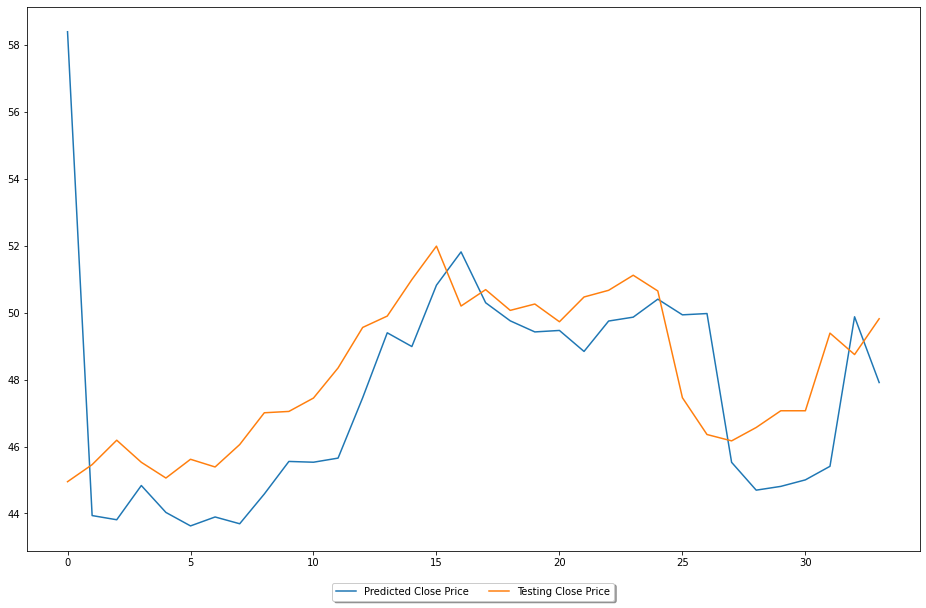

In [39]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()